# Project Song

Author: Justine Huynh

Date: 29 November 2020

## Problem

There are many factors that determine whether a song becomes very popular, or even becomes a major hit. But what are these factors? Which factors are considered the most pivotal in determining a song's popularity?

## Background

Most people have favorite songs or songs they prefer to listen to over others. Some people love music so much they have dedicated a musical database to songs.

Ultimate Music Database is a database that has an "(almost) complete database" of popular music. UMD shows top singles and top albums in multiple regions such as the UK, Luxembourg, etc for multiple years.

- For each specific region, ranks the top 100 songs each week 

In this project, we will be looking at the top 100 songs in the UK.

# Methods I Considered Using

- Scrape just the UMD website using `Beautiful Soup` for the year 2020 from January to end of October
- Visualize some factors (artist, release date, etc) that determine song placement
- Given the song's name, artist, release date, etc for the month of November, determine each song's placement using a pipeline.
- Test which model is best: Gaussian Naive Bayes, K Nearest Neighbors, Decision Tree Regressor, Random Forest Regressor

### Slight Problem

- Not enough information about the characteristics of each song
- Songs are "sticky." New songs that are popular tend to have the same placement as the previous weeks -> time series data

# Methods I Actually Used

### Scraping Data
Classification: This project will see the factors that determine whether a song becomes a hit in the UK.

- `Beautiful Soup` to scrape the top 100 NEW songs who were a hit in UK from the data tables from the period start of 2019 to end of October 2020. 
- These hit songs will be labeled with a variable `isHit = 1`. 

- Album Of The Year (AOTY), that featured all the songs/albums that came out in 2020. I made sure to grab only the songs that were not included in UK's top 100 songs from 2019 to 2020. 
- These songs were the songs who were not a hit in the UK, specifically `isHit = 0`.

- `Spotipy` API to scrape Spotify music. Specifically, search up all the audio features of the song as well as the artist, album, and release date.

- Taking all the information together, I formed one giant dataframe of all the songs and their characteristics, differentiable by whether they were listed at top 100 hits in the UK or not.


# Methods I Actually Used

### Data Visualization

- Used `plotnine` and `ggplot` (great visuals!) to visualize some factors that are indicators of a song's popularity and whether they became top hits in the UK when they first premiered.

# Methods I Actually Used

### Machine Learning

- Utilize a smooth, streamlined pipeline (can test many different parameters)
- Used stellar classification models: Gaussian Naive Bayes, K Nearest Neighbors, Decision Tree Classifiers, and Random Forest Classifier to predict whether a new song would become a hit in the UK


# Results

### Data Visualization

In [1]:
# for Spotipy
import spotipy # don't forget to write: pip install spotipy on gitbash or cmd or whatever
import spotipy.oauth2 as oauth2
from spotipy.oauth2 import SpotifyClientCredentials
import json
import sys

# Regular python
import pandas as pd
import numpy as np

# For scraping
import requests # For downloading the website
from bs4 import BeautifulSoup # For parsing the website

# For time
import time # make computer go to sleep
import random  # for random numbers
import datetime as dt



# Graphing
from dfply import *
from plotnine import *

# Modeling
from sklearn.tree import DecisionTreeRegressor # Select a model (right now the model doesn't matter)
from sklearn.model_selection import train_test_split # Train-test split
from sklearn.model_selection import KFold # K-fold Cross validation
from sklearn.naive_bayes import GaussianNB # Gaussian
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DTree
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import GridSearchCV
import sklearn.preprocessing as pp
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# For Evaluating Model Perfromance
import sklearn.metrics as m
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import cross_validate

In [2]:
myUMD = pd.read_csv("UMD.csv")
fullSongs = pd.read_csv("fullSongs.csv")

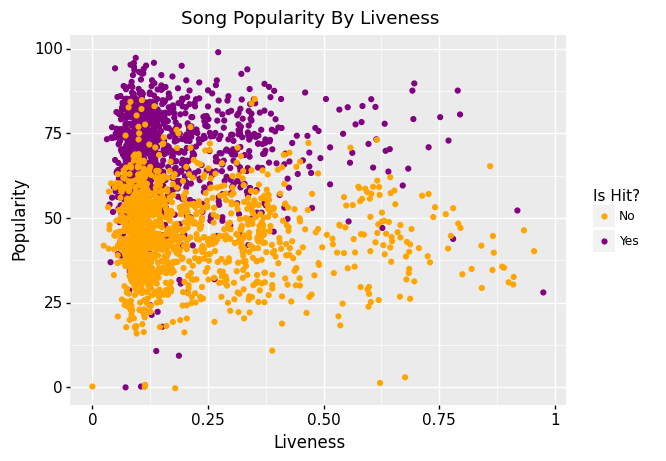

<ggplot: (175006347322)>

In [56]:
(
    fullSongs >>
    select(X.liveness, X.valence, X.popularity, X.isHit) >>
    ggplot() +
    geom_point(aes(x = "liveness", y = "popularity", color = "factor(isHit)"), position = "jitter") +
    labs(
        x = "Liveness",
        y = "Popularity",
        title = "Song Popularity By Liveness",
        color = "Is Hit?"
    ) +
    scale_color_manual(labels = ["No", "Yes"],
                      values = ["orange", "Purple"]) +
    theme(axis_text = element_text(color = "black", size = 11)) +
    theme(axis_title = element_text(color = "black", size = 12))
)

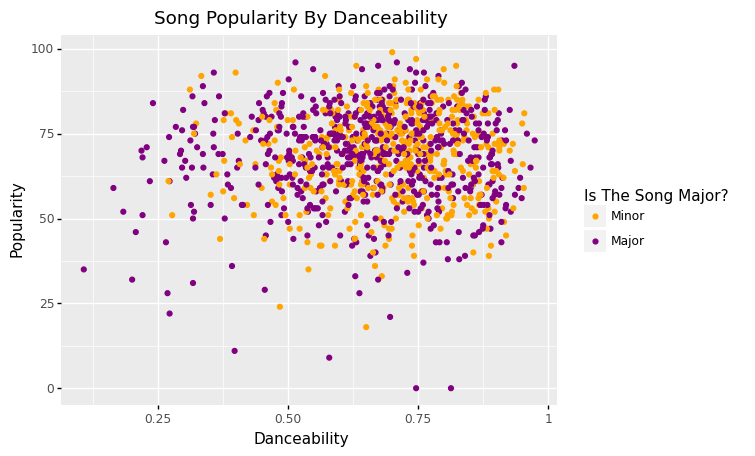

<ggplot: (175011049858)>

In [55]:
(
    myUMD >>
    ggplot() +
    geom_point(aes(x = "danceability", y = "popularity", color = "factor(mode)")) +
    labs(
        x = "Danceability",
        y = "Popularity",
        title = "Song Popularity By Danceability",
        color = "Is The Song Major?"
    ) +
    scale_color_manual(values = ["orange", "purple"],
                      labels = ["Minor", "Major"])

)

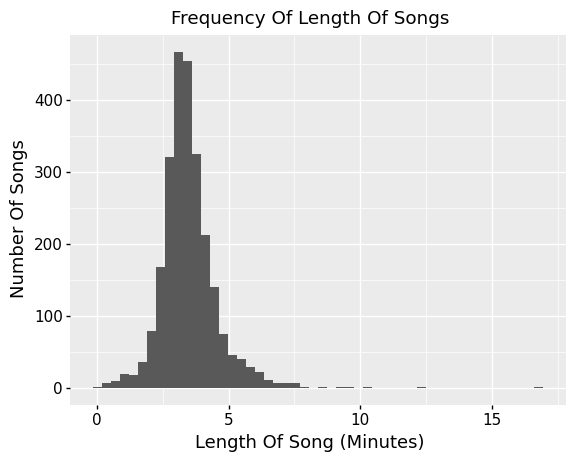

<ggplot: (175007421362)>

In [5]:
(
    fullSongs >>
    mutate(duration_sec = X.duration_ms/1000) >>
    mutate(duration_min = X.duration_sec/60) >>
    ggplot() +
    geom_histogram(aes(x = "duration_min"), bins = 50) +
    labs(
        x = "Length Of Song (Minutes)",
        y = "Number Of Songs",
        title = "Frequency Of Length Of Songs"
    ) +
    theme(axis_text = element_text(color = "black", size = 11)) +
    theme(axis_title = element_text(color = "black", size = 13)) 
)

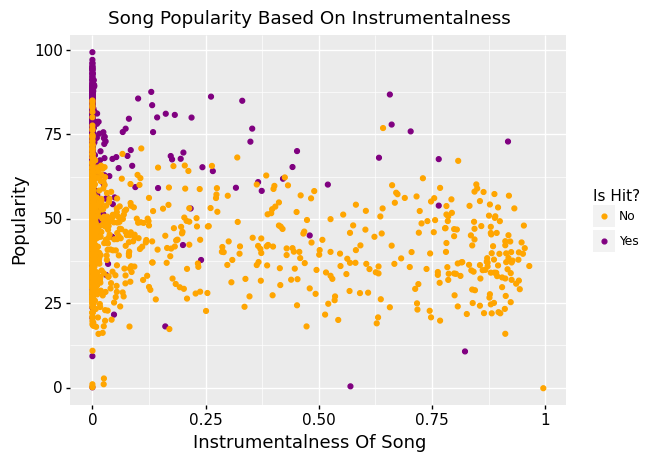

<ggplot: (175011220143)>

In [60]:
(
    fullSongs >>
    select(X.instrumentalness, X.isHit, X.popularity) >>
    ggplot() +
    geom_point(aes(x = "instrumentalness", y = "popularity", color = "factor(isHit)"), position = "jitter") +
    labs(
        x = "Instrumentalness Of Song",
        y = "Popularity",
        title = "Song Popularity Based On Instrumentalness",
        color = "Is Hit?"
    ) +
    theme(axis_text = element_text(color = "black", size = 11)) +
    theme(axis_title = element_text(color = "black", size = 13)) +
    scale_color_manual(values = ["orange", "purple"],
                      labels = ["No", "Yes"])
)

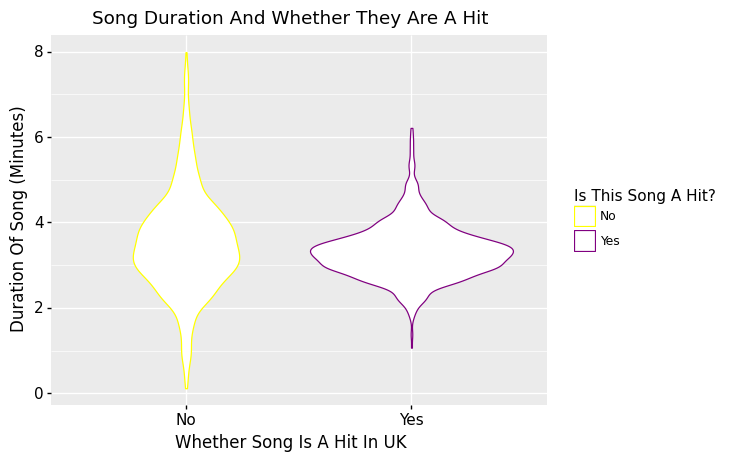

<ggplot: (175007406379)>

In [6]:
meanMins = (fullSongs >>
 group_by(X.isHit) >>
 mutate(duration_min = X.duration_ms/(1000*60)) >>
 summarize(meanMin = X.duration_min.mean())
)



(
    fullSongs >>
    mutate(duration_min = X.duration_ms/(1000*60)) >>
    mask(X.duration_min <= 8) >>
    ggplot() +
    geom_violin(aes(x = "factor(isHit)", y = "duration_min", color = "factor(isHit)")) +
    labs(
        x = "Whether Song Is A Hit In UK",
        y = "Duration Of Song (Minutes)",
        title = "Song Duration And Whether They Are A Hit",
        color = "Is This Song A Hit?"
    ) +
#     geom_hline(yintercept = meanMins["meanMin"][0], color = "yellow") +
#     geom_text(label = meanMins["meanMin"][0], position = "stack") +
#     geom_hline(yintercept = meanMins["meanMin"][1], color = "purple") +
    theme(axis_title = element_text(color = "black", size = 12)) +
    theme(axis_text = element_text(color = "black", size = 11)) +
    scale_color_manual(values = ["yellow", "purple"],
                      labels = ["No", "Yes"]) +
    scale_x_discrete(labels = ["No", "Yes"])
)

## Modeling 

In [4]:
# fullSongs = pd.read_csv("fullSongs.csv")

In [3]:
fullSongsCopy = fullSongs.copy()
keyDummies = pd.get_dummies(fullSongs["key"], drop_first = True, prefix = "key")
fullSongsCopy = pd.concat([fullSongsCopy, keyDummies], axis = 1)

# We have a random column named Unnamed, so delete it
fullSongsCopy.drop(["Unnamed: 0", "key"], axis = 1, inplace = True)
fullSongsCopy.columns

Index(['album', 'artist', 'trackNumber', 'id', 'name', 'uri', 'release_date',
       'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
       'instrumentalness', 'liveness', 'loudness', 'mode', 'popularity',
       'speechiness', 'tempo', 'time_signature', 'valence', 'isHit', 'key_1.0',
       'key_2.0', 'key_3.0', 'key_4.0', 'key_5.0', 'key_6.0', 'key_7.0',
       'key_8.0', 'key_9.0', 'key_10.0', 'key_11.0'],
      dtype='object')

In [4]:
Y = fullSongsCopy.isHit
XData = (fullSongsCopy >> 
         select(~X.isHit)
        )
    

X_train, X_test, Y_train, Y_test = train_test_split(XData, Y, test_size=0.25, random_state = 420)

In [25]:
# (0) Split the data 
X_train, X_test, Y_train, Y_test = train_test_split(XData, Y, test_size=.25, random_state = 420)
# try random_state: 202011

# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits = 10, shuffle = True, random_state=111)

# (2) Next specify the preprocessing steps
# min-max scale these 3 variables: Records, Job, Debt, Income, Home
# we'll see how to preprocess categorical variables next week: 11/18/2020 November 18
# 
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), 
                ["danceability", "duration_ms", "energy", "loudness", "mode", "instrumentalness", "popularity",
                 "speechiness", "tempo", "trackNumber"])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
# spawn a preprocess object
# leave model as blank...cuz we're gonna spawn one eventually...
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])
# fun fact: we don't even have to use the word "model" We could use a random name, like "duck"
# or "P'Dean"

# but please, "model" is a place_holder.
# You change the weird "model" into "P'Dean", you'll have to write "P'Dean"

# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    
    
    
    
    # Gaussian Naive Bayes
    {'model' : [GaussianNB()]},
    
    # Linear Model
    #{'model' : [LM()]},
    # Actually, don't use a linear model. Because we are classifying, 
    # Not regressing (numeric predictions)
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30],
     'model__leaf_size' : [40]}, # Notice the double underscore after model
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,4],
    "model__min_samples_leaf" : [1, 5, 7]},
    
    
    # The Bagging decision tree model 
    #{'model': [Bag()]},
    
    # Random forest (Classifier) with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[4, 5, 6, 7, 9],
     'model__n_estimators':[600, 1000, 1500, 1700]},
]


# (5) Put it all together in the grid search
# search_space was the tuing parameters or something
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['danceability',
                                                                          'duration_ms',
                                                                          'energy',
                                                                          'loudness',
                                                                          'mode',
                                                                          'instrumentalness',
                                                                          'popularity',
                                                                          'speechiness',
      

## Machine Learning Results
4 models
1. Gaussian Naive Bayes
2. K Nearest Neighbors
3. Decision Tree Classifier
4. Random Forest Classifier (the chosen one)

Best parameters:
- Max depth: 9
- Number Of Estimators (Trees In Forest): 1500

Performance On Training Data

- AUC Score: 98.10%
- Accuracy: 98%

Performance On Testing Data
- AUC Score: 98%
- Accuracy: 88%

In [28]:
print("The Parameters")
print(search.get_params)
rf_mod = search.best_estimator_
print()
print("Best Estimator")
print(rf_mod)
# <img src = “path/ ”>
# <img src = “path/ ” width = 1000 height = 1000>
# ![](path)


The Parameters
<bound method BaseEstimator.get_params of GridSearchCV(cv=KFold(n_splits=10, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['danceability',
                                                                          'duration_ms',
                                                                          'energy',
                                                                          'loudness',
                                                                          'mode',
                                                                          'instrumentalness',
                                                                          'popularity',
                                      

In [29]:
search.best_params_

{'model': RandomForestClassifier(max_depth=9, n_estimators=1500),
 'model__max_depth': 9,
 'model__n_estimators': 1500}

The best model would be: Random Forest Classifier
- Max Depth: 9
- Number Of Estimators (Trees In Forest): 1500

In [30]:
# Best score
print("Best Score: ", search.best_score_)

# AUC curve
print("AUC score:", m.roc_auc_score(Y_train, rf_mod.predict(X_train)))

# Accuracy
print("Accuracy:", m.accuracy_score(Y_train, rf_mod.predict(X_train)))

Best Score:  -0.1095969830012383
AUC score: 0.9804099222912213
Accuracy: 0.9798835362625727


In [31]:
vi = permutation_importance(rf_mod, X_train,Y_train, n_repeats = 25) 
# make n_repeats bigger to repeat the random process of permutation.
# Try not to shuffle the data in a way that the model does surprisingly better. Or worse.
# SO do more repeats.

In [17]:
# We have data togeher...
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable= X_train.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std'] # 2 STDs below mean
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std'] # 2 STDs above mean.

# But sort in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,popularity,0.281694,0.009914,0.261865,0.301523
1,trackNumber,0.084404,0.004834,0.074737,0.094071
2,instrumentalness,0.065283,0.005046,0.055191,0.075375
3,danceability,0.040339,0.002460,0.035418,0.045259
4,speechiness,0.027591,0.001902,0.023788,0.031395
5,tempo,0.023462,0.002361,0.018739,0.028185
6,duration_ms,0.021048,0.001872,0.017305,0.024792
7,loudness,0.019735,0.001781,0.016173,0.023298
8,energy,0.013616,0.001697,0.010221,0.017011
9,mode,0.002816,0.000990,0.000836,0.004796


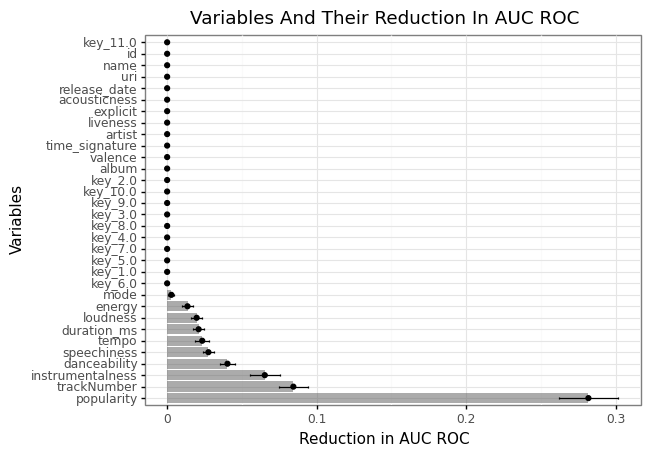

<ggplot: (194660421783)>

In [32]:
# Plot Reduction In AUC curve
(
    ggplot(vi_dat,
          aes(x="variable", y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC", 
         x= "Variables",
        title = "Variables And Their Reduction In AUC ROC")
)

The top factor that determines whether a song will become a hit is `popularity`. To a lesser degree, other factors that determine whether a song becomes a hit is the `trackNumber`, `instrumentalness`, and `danceability`.

# Predicting On New Test Data

In [37]:
# Instantiate the model class
rf = RF(n_estimators= 1500, max_depth=9)
importantFeatures = ["popularity", "trackNumber", "instrumentalness", "danceability", "speechiness", "tempo", 
                     "loudness", "duration_ms", "energy", "mode"]
# gnb.fit(X_train.iloc[:,7:X_train.shape[1]], Y_train) # Train
rf.fit(X_train[importantFeatures], Y_train)

# Predict 
# y_pred = gnb.predict(X_test.iloc[:,7:X_test.shape[1]])
y_pred = rf.predict(X_test[importantFeatures])

# Out-of-sample performance 
print("Accuracy Score:", m.accuracy_score(Y_test, y_pred))
print("ROC AUC Score:", m.roc_auc_score(Y_train, rf_mod.predict(X_train)))
print("Mean Squared Error:", m.mean_squared_error(Y_test, y_pred))

Accuracy Score: 0.8825396825396825
ROC AUC Score: 0.9804099222912213
Mean Squared Error: 0.11746031746031746


In [34]:
probs = rf.predict_proba(X_test[importantFeatures])
probs =  pd.DataFrame(probs,columns=rf.classes_)
probs

,0.0,1.0
0,0.255932,0.744068
1,0.958937,0.041063
2,0.726676,0.273324
3,0.076809,0.923191
4,0.978219,0.021781
...,...,...
625,0.803041,0.196959
626,0.718266,0.281734
627,0.090821,0.909179
628,0.013265,0.986735


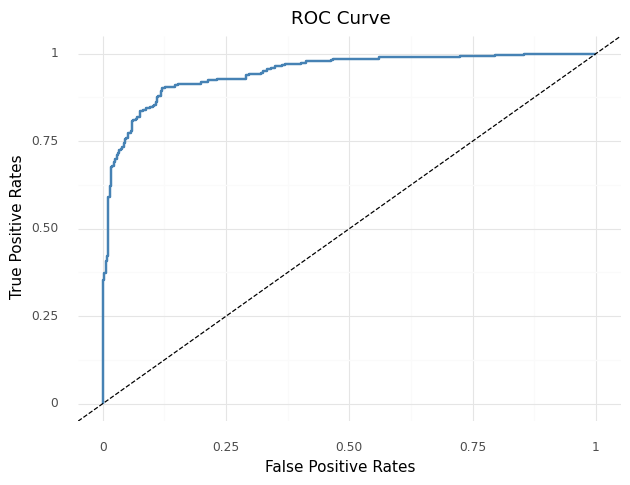

<ggplot: (194660213893)>

In [35]:
# Generate the False Positive Rate and True Positive Rate Given different thresholds
fpr, tpr, thresholds = m.roc_curve(Y_test, probs[1])

# Plot the ROC Curve
( 
    ggplot(pd.DataFrame(dict(fpr=fpr,tpr=tpr)),
           aes(x="fpr",y="tpr")) +
    geom_path(color="steelblue",size=1) +
    geom_abline(intercept=0,slope=1,linetype="dashed") +
    theme_minimal() +
    labs(
        x = "False Positive Rates",
        y = "True Positive Rates",
        title="ROC Curve") +
    theme(figure_size=(7,5))
)

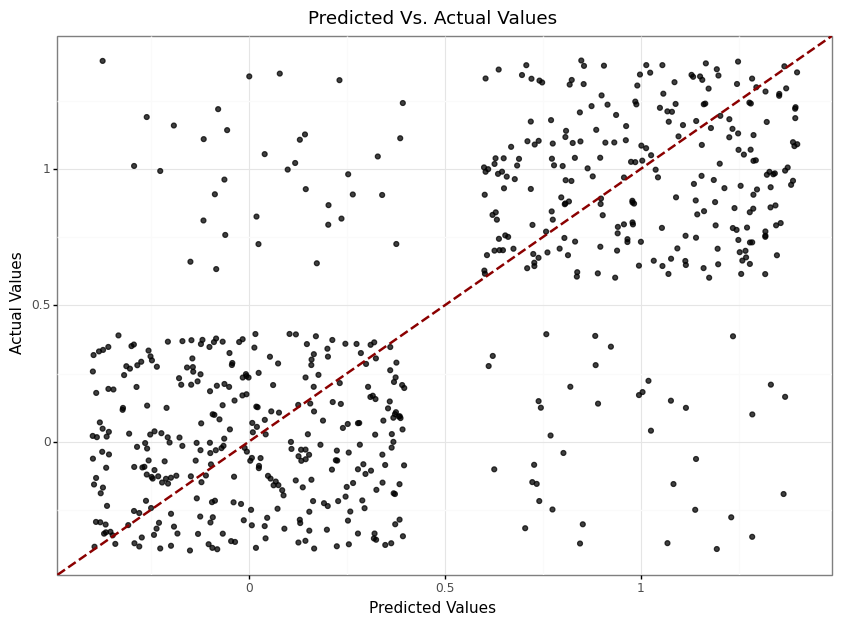

<ggplot: (194660219197)>

In [36]:
(
    ggplot(pd.DataFrame(dict(pred=y_pred,truth=Y_test)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75, position = "jitter") +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    labs(
        x = "Predicted Values",
        y = "Actual Values",
        title = "Predicted Vs. Actual Values"
    ) +
    theme_bw() +
    theme(figure_size=(10,7))
)

# Lessons Learned

- Besides popularity, other factors that determined whether a song became a hit was track number, danceability, and instrumentalness.
- The more complex a tree/model is, the higher the accuracy on training data (be careful of overfitting)
- Reading API is sometimes difficult but helpful
- We need to find positive cases (isHit) and negative cases (isNotHit) for data

# Improvements
- Account for songs who had at least 2 artists or were collaborative
- Small artists who are featured can gain popularity and increase their song popularity

## Github
- https://github.com/jghuynh/Song_Shine